# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the NASA Legacy Surveys Galaxy Atlas (LSLGA).  The final output file--and our starting parent sample of objects--is called *large-galaxies-parent.fits*.

**ToDo**

1. Build unWISE mosaics.
2. Filter and sort the sample; try to remove junk.
3. Include additional metadata in the webpage.

#### We also tested building a parent sample from a query of the NED database but found a number of spurious angular diameter measurements.  Nevertheless, below are some potentially relevant notes.

Our starting catalog is the file *ned-d25min10.txt*, which contains 8,131,378 objects and is the (semi-raw) output of querying the NED database (on 2018 March 26) for all objects with a D(25) isophotal diameter (in any band) greater than 10 arcsec, with no requirements on redshift or object type.  

Next, we run
```bash
% time python parse-ned-sample
```
to restrict the sample to:
  1. "galaxies" (object type "G", "GGroup", "GPair", "GTrpl", or "PofG"), leaving 4,755,411 objects;
  2. objects with an approximate magnitude and angular diameter (from NED, in any band), leaving 4,392,760 objects;
  3. objects in the Legacy Survey / DESI footprint, leaving 3,878,035 objects.

Specifically, we parse and merge various apparent magnitude estimates (from SDSS/r, 2MASS/Ks, RC3/B, and APM/bJ, in that order of priority), and angular diameters (D25), minor-to-major axis ratios (b/a), and position angles (pa) (from SDSS, 2MASS, RC3, and ESO, in that order of priority).

### Imports and paths

In [1]:
import os
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import pandas as pd

In [2]:
import fitsio
from astropy.table import Table, Column, vstack

In [3]:
from PIL import Image, ImageDraw, ImageFont

In [4]:
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [7]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [8]:
PIXSCALE = 0.262

In [9]:
LSLGAdir = os.getenv('LSLGA_DIR')
parentfile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits')
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-dr6-dr7.fits')

### Read the parent sample.

In [10]:
def read_parent():
    parent = Table(fitsio.read(parentfile, ext=1)) # , rows=np.arange(100))
    print('Read {} objects from {}'.format(len(parent), parentfile))
    return parent

In [11]:
parent = read_parent()
parent

Read 3512936 objects from /Users/kevinnapier/data/LSLGA/sample/large-galaxies-parent.fits


galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
bytes30,bytes6,float64,float64,float32,bytes4,bytes39,float64,float64,bytes5,float64,bytes5,float64,bytes5,float64,bytes5,bytes82
SDSS J025901.06+005350.3,G,44.7545416667,0.897277777778,0.134638,N/A,N/A,17.4505409835,nan,r,0.377499997616,r,0.532000005245,r,134.0,r,N/A
SDSS J025952.35+005333.5,G,44.968125,0.892666666667,nan,N/A,N/A,18.5985651438,nan,r,0.178000003099,r,0.465999990702,r,123.0,r,N/A
SDSS J025825.68+004014.1,G,44.607,0.670583333333,nan,N/A,N/A,21.229535371,nan,r,0.322833359241,r,0.0719999969006,r,39.0,r,N/A
SDSS J025940.84+001307.6,G,44.9202083333,0.218777777778,nan,N/A,N/A,19.2581777644,nan,r,0.176666676998,r,0.412999987602,r,15.0,r,N/A
SDSS J025831.82+002854.7,G,44.6325833333,0.481888888889,0.193223,N/A,N/A,17.6786232027,0.149579965748,r,0.211499989033,r,0.759000003338,r,40.0,r,N/A
SDSS J030122.20+002944.1,G,45.3425,0.495583333333,nan,N/A,N/A,19.3794725376,0.184332087891,r,0.180166676641,r,0.321999996901,r,176.0,r,N/A
SDSS J030022.98+010354.8,G,45.0957916667,1.06525,0.165026,SPEC,N/A,18.4965799769,0.149464985574,r,0.200499996543,r,0.615000009537,r,167.0,r,N/A
SDSS J030014.73+003044.9,G,45.0614166667,0.512472222222,0.162356,SPEC,N/A,18.5192791414,0.18410308452,r,0.199500009418,r,0.563000023365,r,52.0,r,N/A
SDSS J025940.77+001921.4,G,44.919875,0.322611111111,nan,N/A,N/A,18.3695309304,0.184011142405,r,0.17950001359,r,0.577000021935,r,10.0,r,N/A


### Generate some QA.

In [12]:
def qa_radec(png=None):
    fig, ax = plt.subplots()
    ax.scatter(parent['ra'], parent['dec'], s=1)
    if png:
        fig.savefig(png)

In [13]:
def qa_d25():
    fig, ax = plt.subplots()
    _ = ax.hist(parent['d25'], bins=100, range=(0, 2))

In [ ]:
qa_radec()

In [ ]:
qa_d25()

In [ ]:
ww = np.where(parent['d25'] == 1.0)[0]
parent[ww]

### Cut to a manageable subset of "large" objects.

In [ ]:
d25min, d25max, maglim = 1.8, 2.0, 16
cat = allcat[(allcat['d25'] > d25min) * (allcat['d25'] < d25max) * (allcat['mag'] < maglim)]
cat

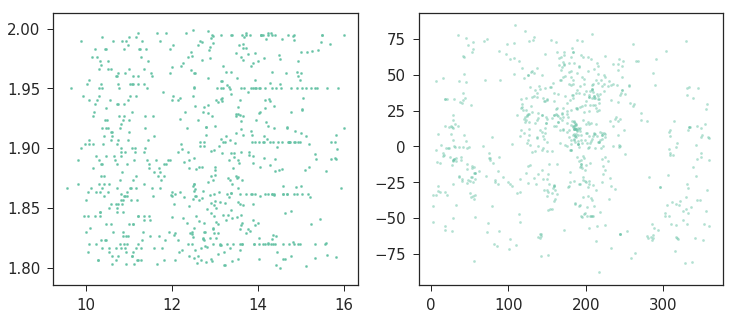

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(cat['mag'], cat['d25'], s=5)
ax2.scatter(cat['ra'], cat['dec'], alpha=0.5, s=5)

### Find the subset of objects in the LS footprint -- this code should really be elsewhere!

In [14]:
def init_survey(dr='dr7'):
    survey = ''
    try:
        del survey
    except:
        pass
    
    if dr.lower() == 'dr7':
        survey = LegacySurveyData(
            survey_dir='/global/cscratch1/sd/desiproc/dr7',
            output_dir=LSLGAdir)
    elif dr.lower() == 'dr6':
        survey = LegacySurveyData(
            survey_dir='/global/cscratch1/sd/dstn/dr6plus',
            output_dir=LSLGAdir)
    
    return survey

In [15]:
def simple_wcs(obj):
    """Build a simple WCS object for a single object."""
    size = np.rint(obj['d25'] * 60 / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(obj['ra'], obj['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [16]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [17]:
def build_sample_one(obj, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given object.
    
    """
    wcs = simple_wcs(obj)

    print('Looking for {} in DR5...'.format(obj['galaxy']))
    try:
        dr = 'dr5'
        survey = init_survey(dr='dr7') # temporary hack to use the DR7 CCDs file
        ccds = survey.ccds_touching_wcs(wcs)
    except:
        print('Looking for {} in DR6...'.format(obj['galaxy']))
        try:
            dr = 'dr6'
            survey = init_survey(dr=dr)
            ccds = survey.ccds_touching_wcs(wcs)
        except:
            return [None, None]
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('For {} found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        obj['galaxy'], len(ccds), obj['ra'], obj['dec'], obj['d25']))
            return [dr, obj]
        
    return [None, None]

In [18]:
def build_sample(cat, use_nproc=nproc):
    """Build the full sample with grz coverage in DR6."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, True) ) # the False refers to verbose=False

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))
            
    # Remove non-matching objects and write out the sample
    rr = list(zip(*result))    
    outcat = vstack(list(filter(None, rr[1])))
    outcat['dr'] = list(filter(None, rr[0]))
    print('Found {}/{} objects in the DR6/DR7 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [19]:
#sample = build_sample(cat)

In [20]:
samplelogfile = os.path.join(LSLGAdir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the LS footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/LSLGA/build-sample.log
Found 395/697 objects in the LS footprint.
Total time = 3.309 seconds.


In [21]:
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)
#sample = sample[:10] # hack!
sample

Writing /global/cscratch1/sd/ioannis/LSLGA/sample/large-galaxies-dr6-dr7.fits


galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes,dr
bytes30,bytes6,float64,float64,float32,bytes4,bytes39,float64,float64,bytes5,float64,bytes5,float64,bytes5,float64,bytes5,bytes82,str3
NGC 4653,G,190.962125,-0.561222222222,0.008776,N/A,SAB(rs)cd,12.8794000833,0.0796841478525,r,1.98466670513,r,0.78100001812,r,44.0,r,The APM position is northeast of the nucleus.,dr5
NGC 6550,G,271.496833333,18.58725,0.007365,N/A,SB0,10.427084815,0.0191887259631,Ks,1.98333334923,Ks,0.560000002384,Ks,160.0,Ks,N/A,dr5
SDSS J145102.49+000017.6,G,222.760416667,0.00488888888889,nan,N/A,N/A,15.8111788603,nan,r,1.80883336067,r,0.425000011921,r,108.0,r,N/A,dr5
NGC 1194,G,45.954625,-1.10375,0.013596,N/A,SA0^+?,12.9540052032,0.0294569464846,r,1.98800003529,r,0.45300000906,r,148.0,r,N/A,dr5
NGC 5797,G,224.100208333,49.6961666667,0.013269,N/A,S0/a,12.4972465733,0.0242545932165,r,1.80816662312,r,0.537999987602,r,112.0,r,N/A,dr6
NGC 3352,G,161.062208333,22.3711944444,0.01916,N/A,S0,12.549176319,0.0232343146509,r,1.88266670704,r,0.669000029564,r,1.0,r,The 2MASS position is 7 arcsec east of the nucleus.,dr5
UGC 07271,G,183.889333333,43.4341111111,0.001825,N/A,SBd?,14.1865969295,0.346619993448,r,1.92183327675,r,0.314999997616,r,159.0,r,N/A,dr6
SDSS J091426.37+232940.2,G,138.609916667,23.4945277778,nan,N/A,N/A,15.1507823107,nan,r,1.98066663742,r,0.0740000009537,r,107.0,r,N/A,dr5
CGCG 428-070,G,334.585416667,13.6237222222,0.024927,N/A,N/A,10.4631290957,0.0595551457487,Ks,1.9333332777,Ks,0.419999986887,Ks,170.0,Ks,N/A,dr5


In [22]:
def qa_radec():
    idr6 = sample['dr'] == 'dr6'
    idr7 = sample['dr'] == 'dr5'

    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=5, label='Parent Catalog')
    ax.scatter(sample['ra'][idr6], sample['dec'][idr6], s=10, label='In DR6')
    ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR5')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower left', fontsize=10, frameon=True)#, ncol=3)

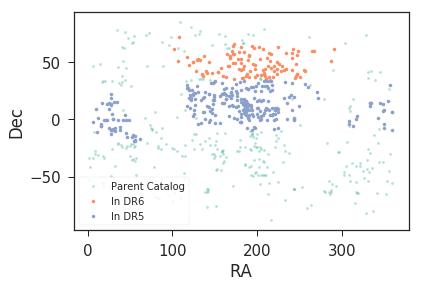

In [23]:
qa_radec()

### Get viewer cutouts of every galaxy.

In [24]:
def get_galaxy(obj, nospace=False):
    galaxy = obj['galaxy']
    if nospace:
        return galaxy.replace(' ','_')
    else:
        return galaxy

In [25]:
def get_layer(obj):
    if obj['dr'] == 'dr6':
        layer = 'mzls+bass-dr6'
    elif obj['dr'] == 'dr5':
        layer = 'decals-dr5'
    return layer

In [26]:
def get_cutouts(sample, clobber=False):
    jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
    if not os.path.isdir(jpgdir):
        os.mkdir(jpgdir)
    baseurl = 'http://legacysurvey.org/viewer-dev/jpeg-cutout'
    for obj in sample:
        layer = get_layer(obj)
        galaxynospace = get_galaxy(obj, nospace=True)
        
        size = np.ceil(2 * obj['d25'] * 60 / PIXSCALE).astype('int16') # [pixels]
        imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
            baseurl, obj['ra'], obj['dec'], PIXSCALE, size, layer)
        
        jpgfile = os.path.join(jpgdir, '{}.jpg'.format(galaxynospace))
        cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
        if os.path.isfile(jpgfile) and not clobber:
            print('File {} exists...skipping.'.format(jpgfile))
        else:
            if os.path.isfile(jpgfile):
                os.remove(jpgfile)
            print(cmd)
            os.system(cmd)

In [27]:
cutlogfile = os.path.join(LSLGAdir, 'get-cutouts.log')
print('Getting viewer cutouts.')
print('Logging to {}'.format(cutlogfile))
t0 = time.time()
with open(cutlogfile, 'w') as log:
    with redirect_stdout(log):
        get_cutouts(sample, clobber=True)
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Getting viewer cutouts.
Logging to /global/cscratch1/sd/ioannis/LSLGA/get-cutouts.log
Total time = 714.627 seconds.


#### Add labels and a scale bar.

In [28]:
barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
fonttype = os.path.join(LSLGAdir, 'Georgia.ttf')

In [29]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [30]:
def add_labels_one(obj, verbose=False):
    jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
    pngdir = os.path.join(LSLGAdir, 'cutouts', 'png')
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)
        
    galaxy = get_galaxy(obj)
    galaxynospace = get_galaxy(obj, nospace=True)
    
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(galaxynospace))
    pngfile = os.path.join(pngdir, '{}.png'.format(galaxynospace))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(galaxynospace))
        
    im = Image.open(jpgfile)
    sz = im.size
    fntsize = np.round(sz[0]/28).astype('int')
    width = np.round(sz[0]/175).astype('int')
    font = ImageFont.truetype(fonttype, size=fntsize)
    draw = ImageDraw.Draw(im)
    # Label the object name--
    draw.text((0+fntsize*2, 0+fntsize*2), galaxy, font=font)
    # Add a scale bar--
    x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
    draw.line((x0, yy, x1, yy), fill='white', width=width)
    im.save(pngfile)    
        
    # Generate a thumbnail
    if True:
        cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
        os.system(cmd)

In [31]:
def add_labels(sample):
    labelargs = list()
    for obj in sample:
        labelargs.append((obj, False))

    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [32]:
%time add_labels(sample)

CPU times: user 64.3 ms, sys: 83.5 ms, total: 148 ms
Wall time: 9.13 s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

```bash
    rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
    rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
and then the website can be viewed here:
  http://portal.nersc.gov/project/cosmo/temp/ioannis/LSLGA    

In [33]:
reject = []
toss = np.zeros(len(sample), dtype=bool)
for ii, gg in enumerate(sample['galaxy']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in gg.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = sample[toss]
else:
    pngrej = []

Rejecting 0 objects.


In [34]:
htmlfile = os.path.join(LSLGAdir, 'cutouts', 'index.html')
htmlfile_reject = os.path.join(LSLGAdir, 'cutouts', 'index-reject.html')
viewerurl = 'http://legacysurvey.org/viewer'

In [35]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            galaxy = get_galaxy(obj)
            galaxynospace = get_galaxy(obj, nospace=True)
            
            pngfile = os.path.join('png', '{}.png'.format(galaxynospace))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(galaxynospace))
            img = 'src="{}" alt="{}"'.format(thumbfile, galaxy)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for obj in pngrow:
            galaxy = get_galaxy(obj)
            layer = get_layer(obj)
            href = '{}/?layer={}&ra={:.8f}&dec={:.8f}&zoom=12'.format(viewerurl, layer, obj['ra'], obj['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, galaxy))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [39]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>Legacy Surveys Large Galaxy Atlas</h1>\n')
    html.write("""<p class="ls-gallery">Each thumbnail links to a larger image while the galaxy 
    name below each thumbnail links to the <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  
    For reference, the horizontal white bar in the lower-right corner of each image represents 
    one arcminute.</p>\n""")
    #html.write('<h2>Large Galaxy Sample</h2>\n')
    html_rows(pngkeep)
    html.write('</body></html>\n')

Splitting the sample into 99 rows with 4 mosaics per row.


In [37]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>Large Galaxies - Rejected</h1>\n')
        html_rows(pngrej)
        html.write('</body></html>\n')

In [38]:
stop

NameError: name 'stop' is not defined

### Generate the color mosaics for each object.¶

In [ ]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [ ]:
def make_coadds_one(obj, scale=PIXSCALE, clobber=False):
    name = np.char.strip(obj['galaxy'])
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        factor = 2.0 # get_factor(obj['type'])
        diam = factor * ma.getdata(obj['d25']) * 60 # diameter [arcsec]
        
        size = np.rint(diam / scale).astype('int') # [pixels]
        print('Generating mosaic for {} (type={}) with width={} pixels.'.format(name, obj['objtype'], size))
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
                      width=size, height=size, stages=['image_coadds'], splinesky=True,
                      early_coadds=True, pixPsf=True, hybridPsf=True, normalizePsf=True,
                      write_pickles=False, depth_cut=False, apodize=True, threads=nproc,
                      do_calibs=False, ceres=False)
            
        sys.stdout.flush()    
        brickname = custom_brickname(obj, prefix='custom-')
        _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                               'legacysurvey-{}-image.jpg'.format(brickname))
        shutil.copy(_jpgfile, jpgfile)
        shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))

In [ ]:
def make_coadds(sample, clobber=False):
    for obj in sample:
        make_coadds_one(obj, clobber=clobber)

In [ ]:
make_coadds_one(sample[2], clobber=True)

In [ ]:
coaddslogfile = os.path.join(LSLGAdir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    with redirect_stdout(log):
        make_coadds(sample, clobber=False)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

In [ ]:
stop